In [1]:
import glob
import copy
import os, sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.path.abspath(".."), "code"))

from plotting_functions import *


from sklearn import datasets
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

# Lecture 18: Multi-class classification and introduction to computer vision 

UBC 2023-24

Instructor: Varada Kolhatkar and Andrew Roth

### Announcements

- Homework 7 due Monday Nov 20th
- Please take a moment to fill out the [midterm survey](https://ubc.ca1.qualtrics.com/jfe/form/SV_eJbEvaNJyq8VPRY)
> Note. Varada's and this section have different surveys. Make sure to use the link above.

### Learning objectives

- Apply classifiers to multi-class classification algorithms.
- Explain the role of neural networks in machine learning, and the pros/cons of using them.
- Explain why the methods we've learned previously would not be effective on image data.
- Apply pre-trained neural networks to classification and regression problems.
- Utilize pre-trained networks as feature extractors and combine them with models we've learned previously.

### iClicker Exercise 19.1 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) It's possible to use word2vec embedding representations for text classification instead of bag-of-words representation. 
- (B) The topic model approach we used in the last lecture, Latent Dirichlet Allocation (LDA), is an unsupervised approach. 
- (C) In an LDA topic model, the same word can be associated with two different topics with high probability.
- (D) In an LDA topic model, a document is a mixture of multiple topics. 
- (E) If I train a topic model on a large collection of news articles with K = 10, I would get 10 topic labels (e.g., sports, culture, politics, finance) as output. 

## Multi-class, meta-strategies

- We have seen examples of multi-class classification but we have not explicitly talked about how different models tackle it. 
- ["ImageNet" computer vision competition](http://www.image-net.org/challenges/LSVRC/), for example, has 1000 classes 
- Can we use decision KNNs for image classification on ImageNet? 
- What about decision trees or random forests? 

- Many linear classification models don't extend naturally to the multiclass case. 
- A common technique is to reduce multiclass classication into several instances of binary classification problems. 
- Two kind of "hacky" ways to reduce multi-class classification into binary classification:  
    - the one-vs.-rest approach
    - the one-vs.-one approach 

### One vs. Rest 

- 1v{2,3}, 2v{1,3}, 3v{1,2}
- Learn a binary model for each class which tries to separate that class from all of the other classes.
- If you have $k$ classes, it'll train $k$ binary classifiers, one for each class. 
- Trained on imbalanced datasets containing all examples.
- Given a test point, get scores from all binary classifiers (e.g., raw scores for logistic regression). 

- The classifier which has the highest score for this class "wins" and that's going to be the prediction for this class. 
- Since we have one binary classifier per class, for each class, we have coefficients per feature and an intercept. 

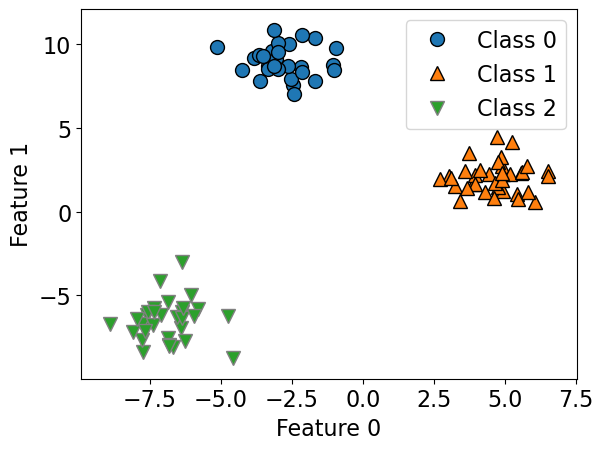

In [2]:
import mglearn
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=3, n_samples=120, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(["Class 0", "Class 1", "Class 2"]);

- This learns three binary linear models.
- So we have coefficients for two features for each of these three linear models. 
- Also we have three intercepts, one for each class. 

In [3]:
lr = LogisticRegression(max_iter=2000, multi_class="ovr")
lr.fit(X_train, y_train)
print("Coefficient shape: ", lr.coef_.shape)
print("Intercept shape: ", lr.intercept_.shape)

Coefficient shape:  (3, 2)
Intercept shape:  (3,)


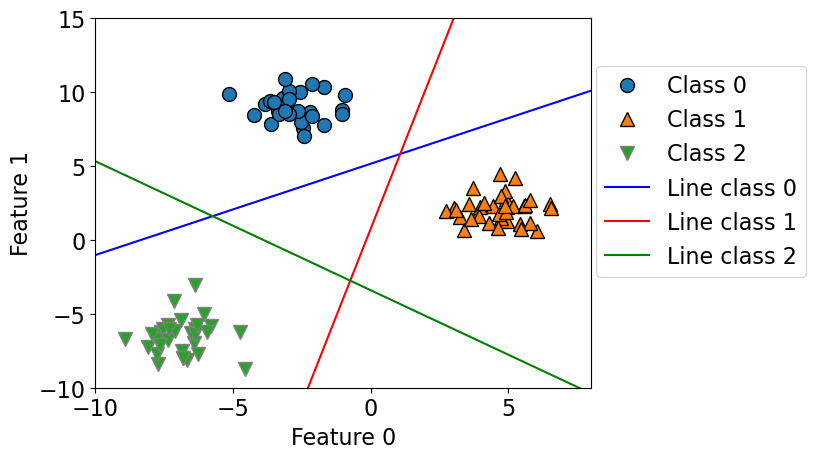

In [4]:
plot_multiclass_lr_ovr(lr, X_train, y_train, 3)

How would you classify the following points? 

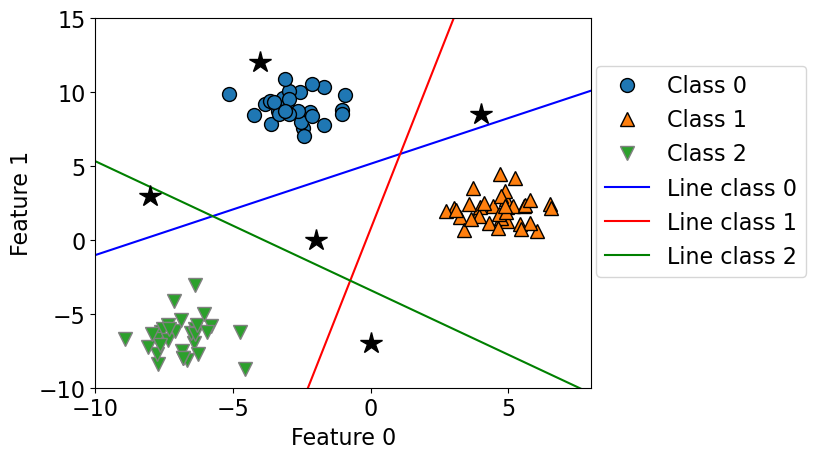

In [5]:
test_points = [[-4.0, 12], [-2, 0.0], [-8, 3.0], [4, 8.5], [0, -7]]            
plot_multiclass_lr_ovr(lr, X_train, y_train, 3, test_points)

The answer is pick the class with the highest value for the classification formula. 

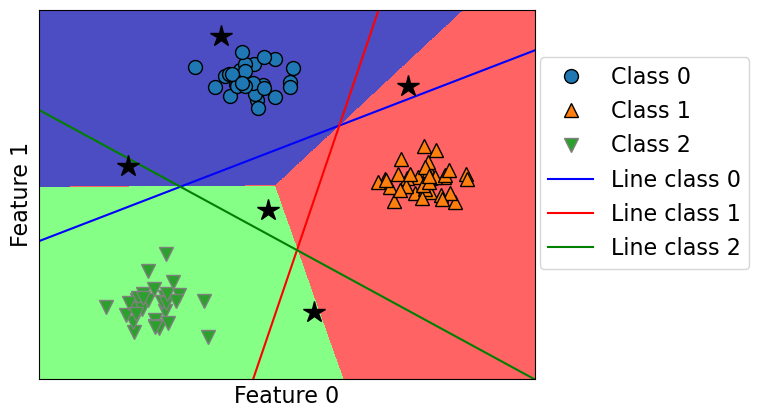

In [6]:
plot_multiclass_lr_ovr(lr, X_train, y_train, 3, test_points, decision_boundary=True)

Let's calculate the raw scores for a test point.

In [7]:
test_points[4]

[0, -7]

In [8]:
lr.coef_

array([[-0.65123329,  1.0536117 ],
       [ 1.35418019, -0.28647501],
       [-0.63320669, -0.72513556]])

In [9]:
lr.intercept_

array([-5.42626721,  0.21616562, -2.46941346])

In [10]:
test_points[4]@lr.coef_.T + lr.intercept_

array([-12.8015491 ,   2.22149069,   2.60653543])

In [11]:
lr.predict_proba([test_points[4]])

array([[1.50344795e-06, 4.92058424e-01, 5.07940073e-01]])

### One Vs. One approach 

- Build a binary model for each pair of classes.
- 1v2, 1v3, 2v3
- Trains $\frac{n \times (n-1)}{2}$ binary classifiers
- Trained on relatively balanced subsets

- Apply all of the classifiers on the test example.
- Count how often each class was predicted.  
- Predict the class with most votes. 

In [12]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

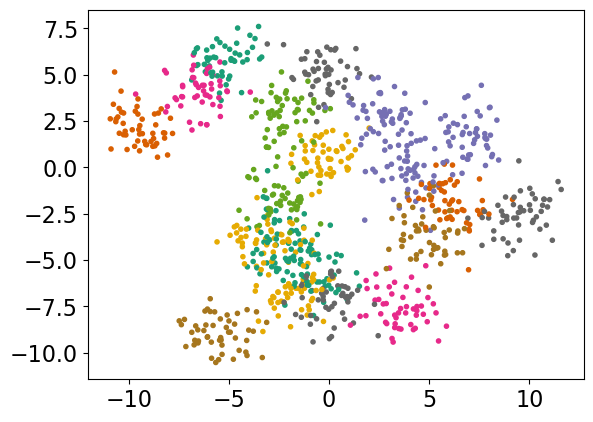

In [13]:
# Let's examine the time taken by OneVsRestClassifier and OneVsOneClassifier

# generate blobs with fixed random generator
X_multi, y_multi = make_blobs(n_samples=1000, centers=20, random_state=300)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi
)

plt.scatter(*X_multi.T, c=y_multi, marker=".", cmap="Dark2");

In [14]:
model = OneVsOneClassifier(LogisticRegression())
%timeit model.fit(X_train_multi, y_train_multi);
print("With OVO wrapper")
print(model.score(X_train_multi, y_train_multi))
print(model.score(X_test_multi, y_test_multi))

422 ms ± 3.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
With OVO wrapper
0.8
0.788


In [15]:
model = OneVsRestClassifier(LogisticRegression())
%timeit model.fit(X_train_multi, y_train_multi);
print("With OVR wrapper")
print(model.score(X_train_multi, y_train_multi))
print(model.score(X_test_multi, y_test_multi))

64.6 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
With OVR wrapper
0.7133333333333334
0.716


### iClicker Exercise 19.2 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) One-vs.-one strategy uses all the available data when training each binary classifier.
- (B) For a 100-class classification problem, one-vs.-rest multi-class strategy will create 100 binary classifiers.
- (C) It would be a good idea to use one-vs.-rest training with a KNN

- We can see that there's a `multi_class` parameter, that can be set to `'ovr'` or `'multinomial'`, or you can have it automatically choose between the two, which is the default.
  - In CPSC 340 the difference between these two approaches is discussed in detail.

In [16]:
model = LogisticRegression(multi_class="multinomial", max_iter=500)
%timeit model.fit(X_train_multi, y_train_multi);
print("With OVR wrapper")
print(model.score(X_train_multi, y_train_multi))
print(model.score(X_test_multi, y_test_multi))

132 ms ± 841 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
With OVR wrapper
0.7893333333333333
0.78


## Introduction to neural networks

- Very popular these days under the name **deep learning**. 
- Neural networks apply a sequence of transformations on your input data.
- They can be viewed a generalization of linear models where we apply a series of transformations. 

- Here is graphical representation of a logistic regression model. 
    - We have 4 features: x[0], x[1], x[2], x[3]

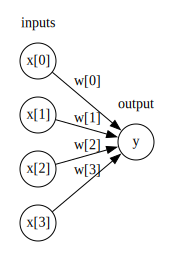

In [17]:
import mglearn

mglearn.plots.plot_logistic_regression_graph()

- Below we are adding one "layer" of transformations in between features and the target. 
- We are repeating the the process of computing the weighted sum multiple times.  
- The **hidden units** (e.g., h[1], h[2], ...) represent the intermediate processing steps. 

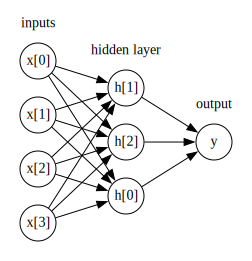

In [18]:
mglearn.plots.plot_single_hidden_layer_graph()

Now we are adding one more layer of transformations.

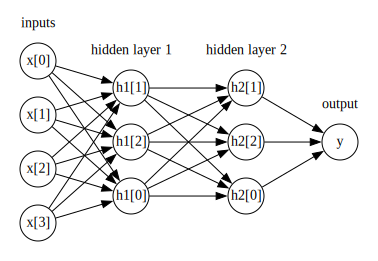

In [19]:
mglearn.plots.plot_two_hidden_layer_graph()

- At a very high level you can also think of them as `Pipelines` in `sklearn`. 
- A neural network is a model that's sort of like its own pipeline
  - It involves a series of transformations ("layers") internally. 
  - The output is the prediction.

<!-- ![](../img/pipeline.png) -->

<img src='../img/pipeline.png' width="600">
    
[Source](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#18)

- Important question: how many features before/after transformation.
  - e.g. scaling doesn't change the number of features
  - OHE increases the number of features
- With a neural net, you specify the number of features after each transformation.
  - In the above, it goes from 4 to 3 to 3 to 1.

To make them really powerful compared to the linear models, we apply a non-linear function to the weighted sum for each hidden node.

### Terminology

- Neural network = neural net
- Deep learning ~ using neural networks

### Why neural networks?

- They can learn very complex functions.
  - The fundamental tradeoff is primarily controlled by the **number of layers** and **layer sizes**.
  - More layers / bigger layers --> more complex model.
  - You can generally get a model that will not underfit. 

### Why neural networks?

- The work really well for structured data:
  - 1D sequence, e.g. timeseries, language
  - 2D image
  - 3D image or video
- They've had some incredible successes in the last 10 years.
- Transfer learning (coming later today) is really useful.  

### Why not neural networks?

- Often they require a lot of data.
- They require a lot of compute time, and, to be faster, specialized hardware called [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit).
- They have huge numbers of hyperparameters are a huge pain to tune.
  - Think of each layer having hyperparameters, plus some overall hyperparameters.
  - Being slow compounds this problem.
- They are not interpretable.

### Why not neural networks?

- When you call `fit`, you are not guaranteed to get the optimal.
  - There are now a bunch of hyperparameters specific to `fit`, rather than the model.
  - You never really know if `fit` was successful or not.
  - You never really know if you should have run `fit` for longer.
- I don't recommend training them on your own without further training
  - Take CPSC 340 and other courses if you're interested.
  - I'll show you some ways to use neural networks without calling `fit`.

### Deep learning software

- scikit-learn has [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) and [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) but they aren't very flexible.
  - In general you'll want to leave the scikit-learn ecosystem when using neural networks.
  - Fun fact: these classes were contributed to scikit-learn by a UBC graduate student.
- There's been a lot of deep learning software out there.

The current big players are:

1. [PyTorch](http://pytorch.org)
2. [TensorFlow](https://www.tensorflow.org)


- Both are heavily used in industry.
- If interested, see [comparison of deep learning software](https://en.wikipedia.org/wiki/Comparison_of_deep_learning_software).

## Break (5 min)

![](../img/eva-coffee.png)

## Introduction to computer vision

- [Computer vision](https://en.wikipedia.org/wiki/Computer_vision) refers to understanding images/videos, usually using ML/AI. 
- Computer vision has many tasks of interest:
  - image classification: is this a cat or a dog?
  - object localization: where is the cat in this image?
  - object detection: What are the various objects in the image? 
  - instance segmentation: What are the shapes of these various objects in the image? 
  - and much more...

![](../img/vision-apps.jpeg)

Source: https://learning.oreilly.com/library/view/python-advanced-guide/9781789957211/

- In the last decade this field has been dominated by deep learning. 
- We will explore **image classification**.

### Dataset

- For this demonstration I'm using a subset of [Kaggle's Animal Faces dataset](https://www.kaggle.com/datasets/andrewmvd/animal-faces). 
- Usually structured data such as this one doesn't come in CSV files. 
- Also, if you are working on image datasets in the real world, they are going to be huge datasets and you do not want to load the full dataset at once in the memory. 
- So usually you work on small batches. 
- You are not expected to understand all the code below. But I'm including it for your reference. 

In [20]:
# Attribution: [Code from PyTorch docs](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer%20learning)

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils
IMAGE_SIZE = 200

data_transforms_bw = {
    "train": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
            transforms.Grayscale(num_output_channels=1),            
            transforms.ToTensor(),
        ]
    ),
    "valid": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),                        
            transforms.Grayscale(num_output_channels=1),            
            transforms.ToTensor(),
        ]
    ),
}
data_dir = "../data/animal_faces"
image_datasets_bw = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms_bw[x])
    for x in ["train", "valid"]
}
dataloaders_bw = {
    x: torch.utils.data.DataLoader(
        image_datasets_bw[x], batch_size=24, shuffle=True, num_workers=4
    )
    for x in ["train", "valid"]
}
dataset_sizes = {x: len(image_datasets_bw[x]) for x in ["train", "valid"]}
class_names = image_datasets_bw["train"].classes

In [21]:
# Get a batch of training data
inputs_bw, classes = next(iter(dataloaders_bw["train"]))

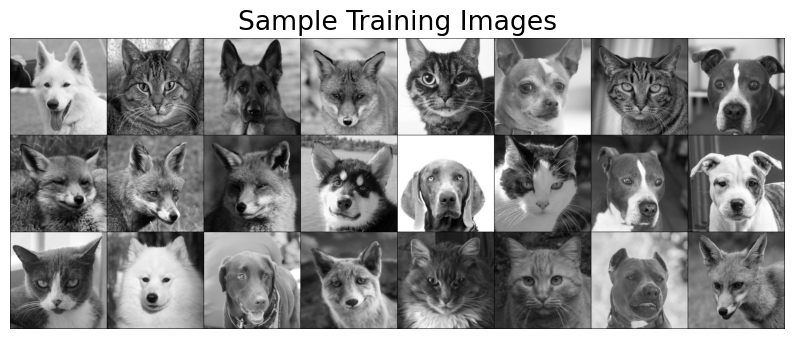

In [22]:
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(inputs_bw, padding=1, normalize=True),(1, 2, 0)));

In [23]:
print(f"Classes: {image_datasets_bw['train'].classes}")
print(f"Class count: {image_datasets_bw['train'].targets.count(0)}, {image_datasets_bw['train'].targets.count(1)}, {image_datasets_bw['train'].targets.count(2)}")
print(f"Samples:", len(image_datasets_bw["train"]))
print(f"First sample: {image_datasets_bw['train'].samples[0]}")

Classes: ['cat', 'dog', 'wild']
Class count: 50, 50, 50
Samples: 150
First sample: ('../data/animal_faces/train/cat/flickr_cat_000002.jpg', 0)


### Logistic regression with flatten representation of images

- How can we train traditional ML models designed for tabular data on image data?
- Let's flatten the images and trained Logistic regression. 

In [24]:
# This code flattens the images in train and validation sets.
# Again you're not expected to understand all the code.
flatten_transforms = transforms.Compose([
                    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                    transforms.Grayscale(num_output_channels=1),
                    transforms.ToTensor(),
                    transforms.Lambda(torch.flatten)])
train_flatten = torchvision.datasets.ImageFolder(root='../data/animal_faces/train', transform=flatten_transforms)
valid_flatten = torchvision.datasets.ImageFolder(root='../data/animal_faces/valid', transform=flatten_transforms)                                                

In [25]:
train_dataloader = torch.utils.data.DataLoader(train_flatten, batch_size=150, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_flatten, batch_size=150, shuffle=True)

In [26]:
flatten_train, y_train = next(iter(train_dataloader))
flatten_valid, y_valid = next(iter(valid_dataloader))

In [27]:
flatten_train.numpy().shape

(150, 40000)

- We have flattened representation (40_000 columns) for all 150 training images. 
- Let's train dummy classifier and logistic regression on these flattened images.  

In [28]:
dummy = DummyClassifier()
dummy.fit(flatten_train.numpy(), y_train)
dummy.score(flatten_train.numpy(), y_train)

0.3333333333333333

In [29]:
dummy.score(flatten_valid.numpy(), y_train)

0.3333333333333333

In [30]:
lr_flatten_pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=3000))
lr_flatten_pipe.fit(flatten_train.numpy(), y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=3000))])

In [31]:
lr_flatten_pipe.score(flatten_train.numpy(), y_train)

1.0

In [32]:
lr_flatten_pipe.score(flatten_valid.numpy(), y_valid)

0.6666666666666666

- The model is overfitting.
- We are getting poor validation results. 
- Why flattening images is a bad idea?
  - There is some structure in this data. 
  - By "flattening" the image we throw away useful information.

This is what we see

In [33]:
plt.rcParams["image.cmap"] = "gray"

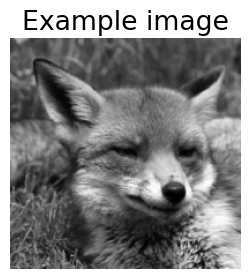

In [34]:
plt.figure(figsize=(3, 3)); plt.axis("off"); plt.title("Example image")
plt.imshow(flatten_train[4].reshape(200,200));

This is what the computer sees

In [35]:
flatten_train[4].numpy()

array([0.2627451 , 0.27450982, 0.30588236, ..., 0.7764706 , 0.7764706 ,
       0.76862746], dtype=float32)

- Hard to classify this!
- [Convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs) can take in images without flattening them. 
  - We won't cover CNNs here, but they are in CPSC 340.

## Transfer learning

- In practice, very few people train an entire CNN from scratch because it requires a large dataset, powerful computers, and a huge amount of human effort to train the model. 
- Instead, a common practice is to download a pre-trained model and fine tune it for your task.   
- This is called **transfer learning**. 
- Transfer learning is one of the most common techniques used in the context of computer vision and natural language processing.
    - In the last lecture we used pre-trained embeddings to create text representations.     

- There are many deep learning architectures out there that have been very successful across a wide range of problem, e.g.: AlexNet, VGG, ResNet, Inception, MobileNet, etc.
- Many of these are trained on famous datasets such as ImageNet (which contains 1.2 million labelled images with 1000 categories)

### ImageNet

- [ImageNet](http://www.image-net.org/) is an image dataset that became a very popular benchmark in the field ~10 years ago. 
    - There are 14 million images and 1000 classes.
    - Here are some example classes. 
    - [Wikipedia article](https://en.wikipedia.org/wiki/ImageNet) on ImageNet


In [36]:
with open("../data/imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]
classes[100:110]

['black swan, Cygnus atratus',
 'tusker',
 'echidna, spiny anteater, anteater',
 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 'wallaby, brush kangaroo',
 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 'wombat',
 'jellyfish',
 'sea anemone, anemone',
 'brain coral']

- The idea of transfer learning is instead of developing a machine learning model from scratch, you use these available pre-trained models for your tasks either directly or by fine tuning them. 
- There are three common ways to use transfer learning in computer vision 
    1. Using pre-trained models out-of-the-box 
    2. Using pre-trained models as feature extractor and training your own model with these features
    2. Starting with weights of pre-trained models and fine-tuning the weights for your task. 
- We will explore the first two approaches.     

### Using pre-trained models out-of-the-box

- Remember this example Varada showed you in the intro video (our very first lecture)?
- We used a pre-trained model vgg16 which is trained on the ImageNet data. 
- We preprocess the given image. 
- We get prediction from this pre-trained model on a given image along with prediction probabilities.  
- For a given image, this model will spit out one of the 1000 classes from ImageNet. 

![](../img/cnn-ex.png)

Source: https://cezannec.github.io/Convolutional_Neural_Networks/

In [37]:
import torch
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg16

In [38]:
def classify_image(img, topn = 4):
    clf = vgg16(weights='VGG16_Weights.DEFAULT') # initialize the classifier with VGG16 weights
    preprocess = transforms.Compose([
                 transforms.Resize(299),
                 transforms.CenterCrop(299),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225]),])

    with open('../data/imagenet_classes.txt') as f:
        classes = [line.strip() for line in f.readlines()]
    
    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0)
    clf.eval()
    output = clf(batch_t)
    _, indices = torch.sort(output, descending=True)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    d = {'Class': [classes[idx] for idx in indices[0][:topn]], 
         'Probability score': [np.round(probabilities[0, idx].item(),3) for idx in indices[0][:topn]]}
    df = pd.DataFrame(d, columns = ['Class','Probability score'])
    return df

In [ ]:
# Predict labels with associated probabilities for unseen images
images = glob.glob("../data/test_images/*.*")
for image in images:
    img = Image.open(image)
    img.load()
    plt.imshow(img)
    plt.show()
    df = classify_image(img)
    print(df.to_string(index=False))
    print("--------------------------------------------------------------")

- We got these predictions without "doing the ML ourselves".
- We are using **pre-trained** `vgg16` model which is available in `torchvision`.
- `torchvision` has many such pre-trained models available that have been very successful across a wide range of tasks: AlexNet, VGG, ResNet, Inception, MobileNet, etc.
- Many of these models have been pre-trained on famous datasets like **ImageNet**. 
- So if we use them out-of-the-box, they will give us one of the ImageNet classes as classification. 

In [ ]:
# Predict labels with associated probabilities for unseen images
images = glob.glob("../data/UBC_img/*.*")
for image in images:
    img = Image.open(image)
    img.load()
    plt.imshow(img)
    plt.show()
    df = classify_image(img)
    print(df.to_string(index=False))
    print("--------------------------------------------------------------")

In [41]:
# Predict labels with associated probabilities for unseen images
# images = glob.glob("../data/savannah/*.*")
# for image in images:
#     img = Image.open(image)
#     img.load()
#     plt.imshow(img)
#     plt.show()
#     df = classify_image(img)
#     print(df.to_string(index=False))
#     print("--------------------------------------------------------------")

- It's not doing very well here because ImageNet don't have proper classes for these images. 
- Here we are using pre-trained models out-of-the-box. 
- Can we use pre-trained models for our own classification problem with our classes? 
- Yes!! 

## Using pre-trained models as feature extractor

- Let's use pre-trained models to extract features.
- We will pass our specific data through a pre-trained network to get a feature vector for each example in the data. 
- The feature vector is usually extracted from the last layer, before the classification layer from the pre-trained network. 
- You can think of each layer a transformer applying some transformations on the input received to that later. 

![](../img/cnn-ex.png)

Source: https://cezannec.github.io/Convolutional_Neural_Networks/

- Once we extract these feature vectors for all images in our training data, we can train a machine learning classifier such as logistic regression or random forest. 
- This classifier will be trained on our classes using feature representations extracted from the pre-trained models.  
- Let's try this out. 
- It's better to train such models with GPU. Since our dataset is quite small, we won't have problems running it on a CPU. 

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cpu


### Reading the data

- Let's read the data. Before we just used 1 colour channel because we wanted to flatten the representation.
- Here, I'm using all three colour channels. 
- Let's read and prepare the data. (You are not expected to understand this code.)

In [43]:
# Attribution: [Code from PyTorch docs](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer%20learning)

IMAGE_SIZE = 200
BATCH_SIZE = 64

data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),
            # transforms.RandomHorizontalFlip(),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),     
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),            
        ]
    ),
    "valid": transforms.Compose(
        [
            # transforms.Resize(256),
            # transforms.CenterCrop(224),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),                        
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),                        
        ]
    ),
}
data_dir = "../data/animal_faces"
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "valid"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4
    )
    for x in ["train", "valid"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "valid"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

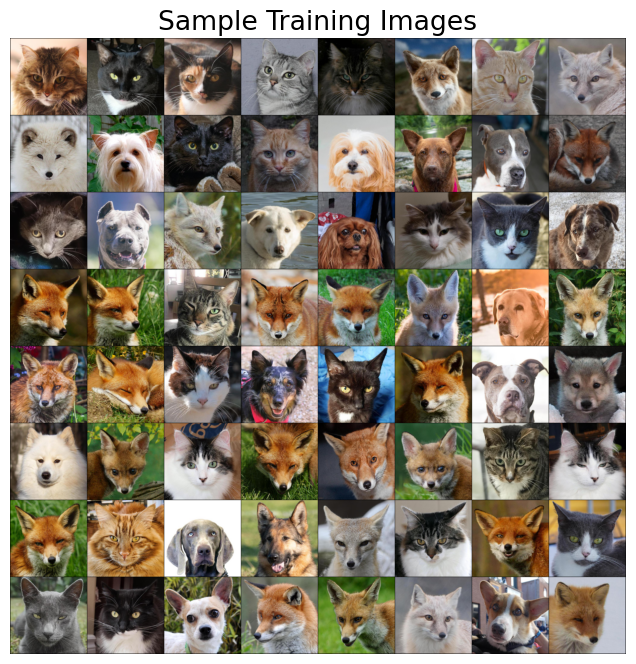

In [45]:
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(inputs, padding=1, normalize=True),(1, 2, 0)));

In [46]:
print(f"Classes: {image_datasets['train'].classes}")
print(f"Class count: {image_datasets['train'].targets.count(0)}, {image_datasets['train'].targets.count(1)}, {image_datasets['train'].targets.count(2)}")
print(f"Samples:", len(image_datasets["train"]))
print(f"First sample: {image_datasets['train'].samples[0]}")

Classes: ['cat', 'dog', 'wild']
Class count: 50, 50, 50
Samples: 150
First sample: ('../data/animal_faces/train/cat/flickr_cat_000002.jpg', 0)


Now for each image in our dataset, we'll extract a feature vector from a pre-trained model called densenet121, which is trained on the ImageNet dataset.  

In [47]:
def get_features(model, train_loader, valid_loader):
    """Extract output of squeezenet model"""
    with torch.no_grad():  # turn off computational graph stuff
        Z_train = torch.empty((0, 1024))  # Initialize empty tensors
        y_train = torch.empty((0))
        Z_valid = torch.empty((0, 1024))
        y_valid = torch.empty((0))
        for X, y in train_loader:
            Z_train = torch.cat((Z_train, model(X)), dim=0)
            y_train = torch.cat((y_train, y))
        for X, y in valid_loader:
            Z_valid = torch.cat((Z_valid, model(X)), dim=0)
            y_valid = torch.cat((y_valid, y))
    return Z_train.detach(), y_train.detach(), Z_valid.detach(), y_valid.detach()

In [48]:
densenet = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
densenet.classifier = nn.Identity()  # remove that last "classification" layer

In [49]:
Z_train, y_train, Z_valid, y_valid = get_features(
    densenet, dataloaders["train"], dataloaders["valid"]
)

In [50]:
Z_train.shape

torch.Size([150, 1024])

The size of each feature vector is 1024 because the size of the last layer in densenet architecture is 1024.  

![](../img/densenet-architecture.png)

Source: https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a

- The features are hard to interpret but they have some important information about the images which can be useful for classification.  
- Let's try out logistic regression on these extracted features. 

In [51]:
pd.DataFrame(Z_train).head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.000466,0.010418,0.000701,0.001084,0.214988,0.670524,0.000258,0.005873,0.312008,0.000191,...,1.015757,1.329988,0.244085,0.000000,0.016992,0.050784,0.374036,2.872947,0.216314,2.147609
1,0.000234,0.004717,0.004709,0.003552,0.096267,0.417313,0.000399,0.002817,0.380481,0.000411,...,1.055866,0.214226,0.229936,0.766309,1.232929,0.597416,0.020700,1.038119,2.094710,0.748593
2,0.000562,0.004004,0.002272,0.001575,0.096109,0.588947,0.000692,0.003586,0.197310,0.000218,...,1.071906,0.163141,0.390323,0.330654,1.427222,1.111930,1.461093,3.069564,0.700509,0.981004
3,0.000189,0.001858,0.002949,0.003655,0.129396,0.942106,0.000939,0.003279,0.107184,0.000411,...,0.375395,1.505707,0.224693,1.589073,1.093113,2.497981,1.543450,0.081415,0.671496,0.620780
4,0.000576,0.003351,0.000918,0.003353,0.114838,0.237181,0.000640,0.002640,0.629871,0.000445,...,1.670473,0.063835,1.211470,0.003894,0.009912,0.145608,1.468171,1.124041,0.032565,2.011959


In [52]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))
pipe.fit(Z_train, y_train)
pipe.score(Z_train, y_train)

1.0

In [53]:
pipe.score(Z_valid, y_valid)

0.8866666666666667

- This is great accuracy for so little data (we only have 150 examples) and little effort of all different types of animals!!!
- With logistic regression and flattened representation of images we got an accuracy of 0.66. 

## Random cool stuff

- [A nice video](https://www.youtube.com/watch?v=oGvHtpJMO3M) which gives a high-level introduction to computer vision.
- Style transfer: given a "content image" and a "style image", create a new image with the content of one and the style of the other.
  - Here is the [original paper from 2015](https://arxiv.org/pdf/1508.06576.pdf), see Figure 2.
  - Here are more in [this 2016 paper](https://arxiv.org/pdf/1601.04589.pdf); see, e.g. Figures 1 and 7.
  - This has been done for video as well; see [this video from 2016](https://www.youtube.com/watch?v=Khuj4ASldmU).
- [Image captioning](https://cs.stanford.edu/people/karpathy/sfmltalk.pdf): Transfer learning with NLP and vision 
- Colourization: see [this 2016 project](http://iizuka.cs.tsukuba.ac.jp/projects/colorization/en/).
- Inceptionism: let the neural network "make things up"
  - [2015 article](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
  - "Deep dream" [video from 2015](https://www.youtube.com/watch?v=dbQh1I_uvjo).


## Summary

- Multi-class classification refers to classification with >2 classes.
  - Most sklearn classifiers work out of the box.
  - With `LogisticRegression` the situation with the coefficients is a bit funky, we get 1 coefficient per feature per class. 
- Flattening images throws away a lot of useful information (sort of like one-hot encoding on ordinal variable!).
- Neural networks are a flexible class of models.
  - They are hard to train - a lot more on that in CPSC 340.
  - They generally require leaving the sklearn ecosystem to tensorflow or pytorch.
  - They are particular powerful for structured input like images, videos, audio, etc.
- The good news is we can use pre-trained neural networks.
  - This saves us a huge amount of time/cost/effort/resources.
  - We can use these pre-trained networks directly or use them as feature transformers. 
- My general recommendation: don't use deep learning unless there is good reason to.